In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


def load_and_preprocess(filename):
    df = pd.read_csv(filename)
    df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])

    # Columns for which you want to get the sum
    sum_cols = ['FCH4_F', 'P_F']

    # Columns for which you want to get the mean
    mean_cols = ['TA_F', 'WTD_F', 'PA_F', 'G_F', 'H_F', 'NEE_F', 'LE_F', 
                 'bdod_0-5cm_mean', 'cec_0-5cm_mean', 'nitrogen_0-5cm_mean', 
                 'phh2o_0-5cm_mean', 'soc_0-5cm_mean']

    # Use agg() to specify how you want to aggregate each column
    df_grouped = (df.groupby([df['TIMESTAMP'].dt.to_period('Y'), 'SITE_NAME'])
                  .agg({**{col: 'sum' for col in sum_cols}, **{col: 'mean' for col in mean_cols}})
                  .reset_index())

    # Fill NA values in sum_cols with the sum of the respective columns
    for col in sum_cols:
        df_grouped[col] = df_grouped[col].fillna(df_grouped[col].sum())
    
    # Fill NA values in mean_cols with the mean of the respective columns
    for col in mean_cols:
        df_grouped[col] = df_grouped[col].fillna(df_grouped[col].mean())

    return df_grouped, sum_cols + mean_cols


def standardize_data(df_grouped, num_cols):
    scaler = StandardScaler()
    df_grouped_scaled = df_grouped.copy()
    df_grouped_scaled[num_cols] = scaler.fit_transform(df_grouped[num_cols])
    return df_grouped_scaled


def perform_pca(df_scaled, n_components=10):
    pca = PCA(n_components=n_components)

    # Ensure only numerical columns are retained for PCA
    df_scaled = df_scaled.select_dtypes(include=[np.number])

    principalComponents = pca.fit_transform(df_scaled)
    principalDf = pd.DataFrame(data=principalComponents, columns=[f'PC{i}' for i in range(1, n_components + 1)])

    # Compute the explained variance
    explained_variance = pca.explained_variance_ratio_
    print("Explained variance for each principal component:", explained_variance*100,"%")

    # Get the loadings
    loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i}' for i in range(1, n_components + 1)], index=df_scaled.columns)

    # Create a heatmap of the loadings
    plt.figure(figsize=(10, 10))
    sns.heatmap(loadings, annot=True, cmap='coolwarm')
    plt.show()

    return pca, principalDf, loadings


def generate_biplot(df, principalDf, clusters, pca, num_cols, cluster_type):
    """Generate a biplot."""

    # Create a new dataframe to hold the principal components, cluster information, and original Climate information
    df_pca = pd.concat([principalDf, pd.Series(clusters, name='cluster')], axis=1)

    # Generate the biplot
    plt.figure(figsize=(10, 10))
    sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue= 'cluster', style='cluster', palette='viridis')
    plt.title(f'Biplot of Soil Data Clusters: {cluster_type}')

    # Add the feature (component) correlations as vectors
    features = range(pca.n_components_)
    vectors = pca.components_.T * np.sqrt(
        pca.explained_variance_)  # vectors are scaled by the square root of eigenvalues for length

    # Add arrows to the biplot to represent the vectors
    for i, v in enumerate(vectors):
        plt.arrow(0, 0, 3 * v[0], 3 * v[1], head_width=0.1, head_length=0.1, linewidth=2, color='red')
        plt.text(v[0] * 3, v[1] * 3, num_cols[i], color='black', ha='center', va='center', fontsize=8)

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)
    plt.show()


def perform_clustering(df_scaled, algorithm, **kwargs):
    """Perform clustering on the data."""
    model = algorithm(**kwargs)
    clusters = model.fit_predict(df_scaled)
    return clusters


def gradient_biplot(df, principalDf, clusters, pca, num_cols, cluster_type, data_variable):
    """Generate a biplot."""
    
    # Create a new dataframe to hold the principal components, cluster information, and original Climate information
    df_pca = pd.concat([principalDf, df[data_variable], pd.Series(clusters, name='cluster')], axis=1)
    
    # Generate the biplot
    plt.figure(figsize=(10, 10))
    sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue=data_variable, style='cluster', palette='viridis')
    plt.title(f'Biplot of Soil Data Clusters: {cluster_type}')
    
    # Add the feature (component) correlations as vectors
    features = range(pca.n_components_)
    vectors = pca.components_.T * np.sqrt(pca.explained_variance_)  # vectors are scaled by the square root of eigenvalues for length
    
    # Add arrows to the biplot to represent the vectors
    for i, v in enumerate(vectors):
        plt.arrow(0, 0, 3 * v[0], 3 * v[1], head_width=0.1, head_length=0.1, linewidth=2, color='red')
        plt.text(v[0] * 3, v[1] * 3, num_cols[i], color='black', ha='center', va='center', fontsize=8)
    
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)
    plt.show()

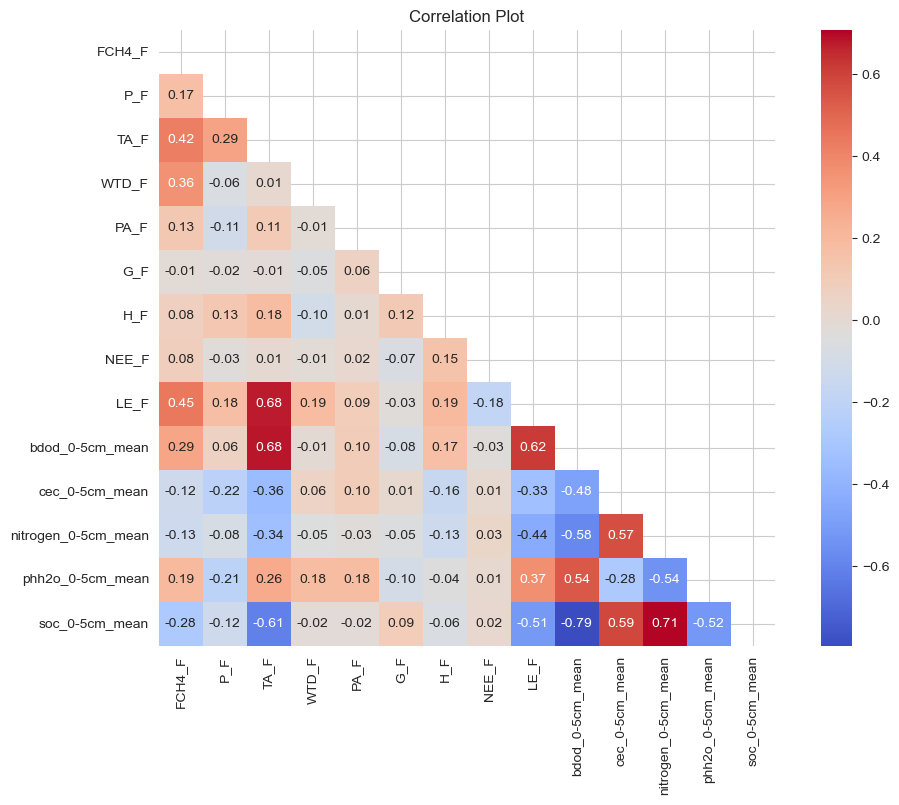

In [14]:
# Load and preprocess the data
df_grouped, num_cols = load_and_preprocess('merged_data.csv')
df_grouped_scaled = standardize_data(df_grouped, num_cols)

# Compute the correlation matrix
corr_matrix = df_grouped_scaled[num_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set the style to "whitegrid"
sns.set_style("whitegrid")

# Create the correlation plot
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, mask=mask)
plt.title('Correlation Plot')
plt.show()

Explained variance for each principal component: [31.34725984 10.75427045 10.16624747  8.45894827  8.03919234  7.01130841
  5.58054822  4.81546822  3.48053718  3.09593495] %


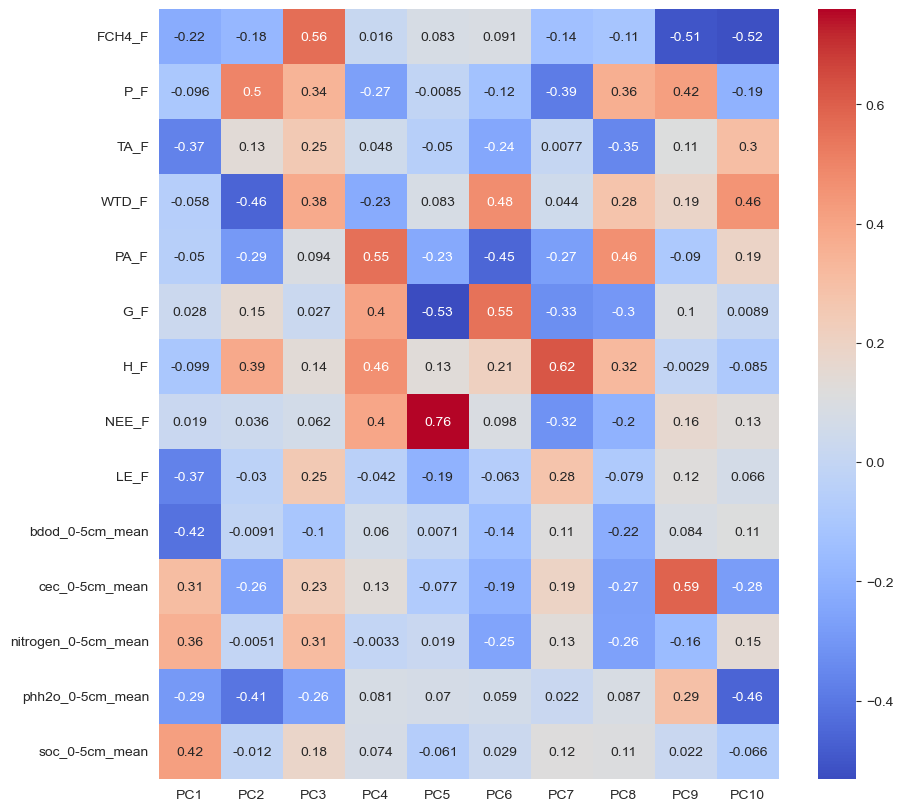

In [15]:
# Assuming df_scaled is your scaled dataframe
pca_model, reduced_df, loadings = perform_pca(df_grouped_scaled)

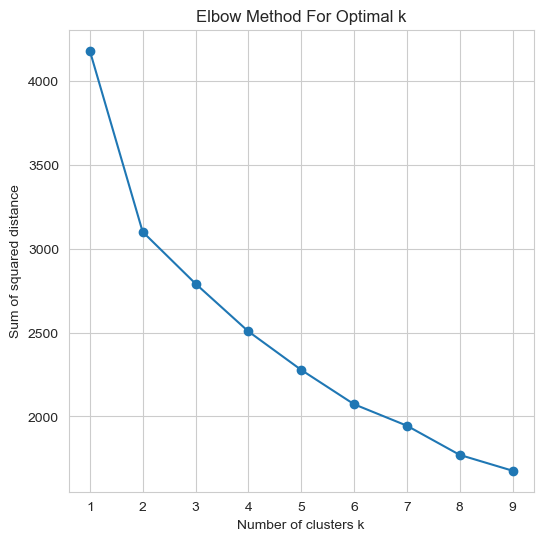

In [16]:
# Create elbow plot for best k 
data = reduced_df.values

sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(data)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel('Number of clusters k')
plt.ylabel('Sum of squared distance')
plt.title('Elbow Method For Optimal k')
plt.show()

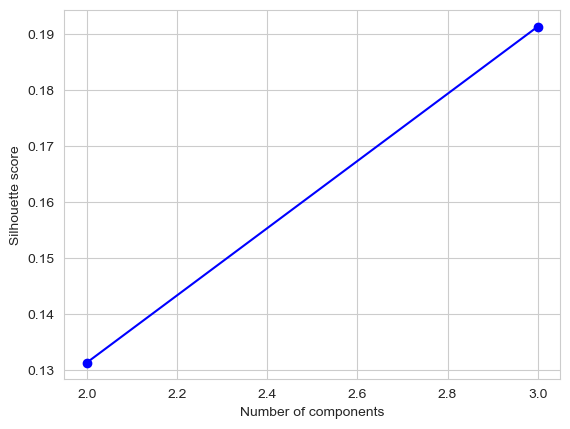

In [19]:
# create a list of candidate n_components values
n_components_list = range(2, 4)

# calculate silhouette scores for each n_components value
silhouette_scores = []
for n in n_components_list:
    gmm = GaussianMixture(n_components=n, random_state=1)
    labels = gmm.fit_predict(data)
    score = silhouette_score(data, labels)
    silhouette_scores.append(score)

# plot silhouette scores vs n_components
plt.plot(n_components_list, silhouette_scores, 'bo-')
plt.xlabel('Number of components')
plt.ylabel('Silhouette score')
plt.show()

In [20]:
best_eps = 0
best_min_samples = 0
best_silhouette_score = -1

# Define the range of values for eps and min_samples
eps_values = [0.5, 1, 1.5, 2]
min_samples_values = [5, 10, 15, 20]

# Iterate over different parameter combinations
for eps in eps_values:
    for min_samples in min_samples_values:
        # Apply DBSCAN clustering
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(data)
        
        # Check if there is only one unique cluster label
        if len(np.unique(clusters)) == 1:
            continue
        
        # Calculate the silhouette score
        silhouette = silhouette_score(data, clusters)
        
        # Check if the current parameter combination is better
        if silhouette > best_silhouette_score:
            best_silhouette_score = silhouette
            best_eps = eps
            best_min_samples = min_samples

# Print the best parameter values and silhouette score
print("Best eps:", best_eps)
print("Best min_samples:", best_min_samples)
print("Best silhouette score:", best_silhouette_score)

Best eps: 2
Best min_samples: 5
Best silhouette score: 0.22790942273332335


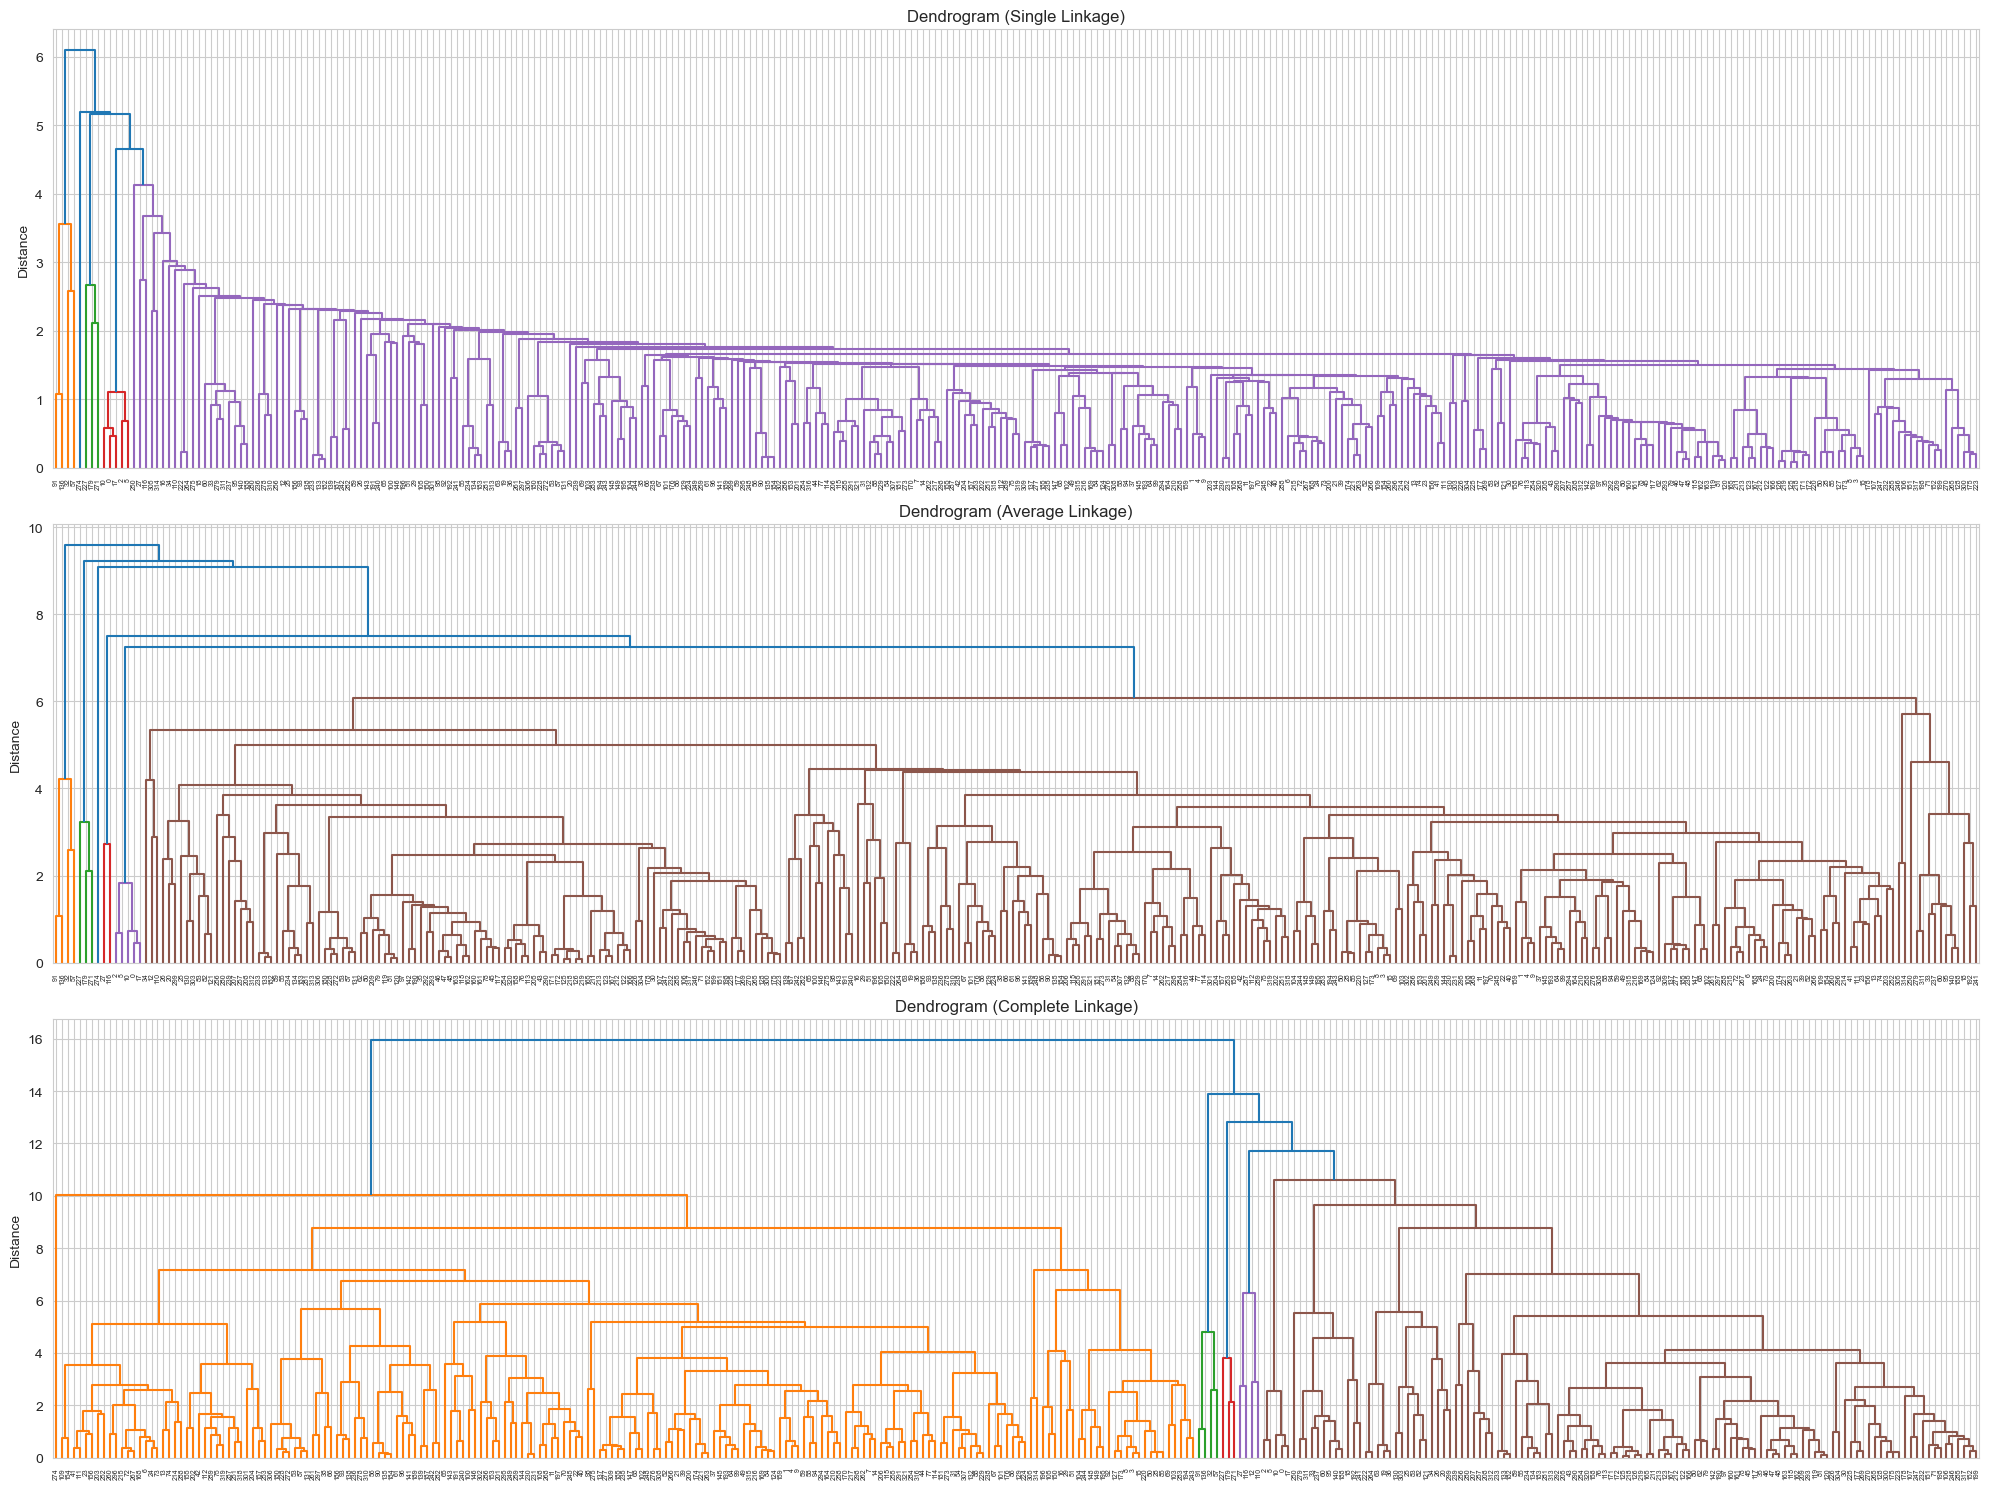

In [21]:
from scipy.cluster.hierarchy import dendrogram, linkage

# List of all linkage methods to check
methods = ['single', 'average', 'complete']

# Create a subplot image
fig, axs = plt.subplots(len(methods), 1, figsize=(20, 15))

# Enumerate through the list of all methods, get linkage, and plot dendrogram
for i, method in enumerate(methods):
    Z = linkage(data, metric='euclidean', method=method)

    dendrogram(Z, ax=axs[i])

    axs[i].set_title(f'Dendrogram ({method.capitalize()} Linkage)')
    axs[i].set_ylabel('Distance')

plt.tight_layout()
plt.show()

Running KMeans...
Explained variance for each principal component: [31.34725984 10.75427045] %


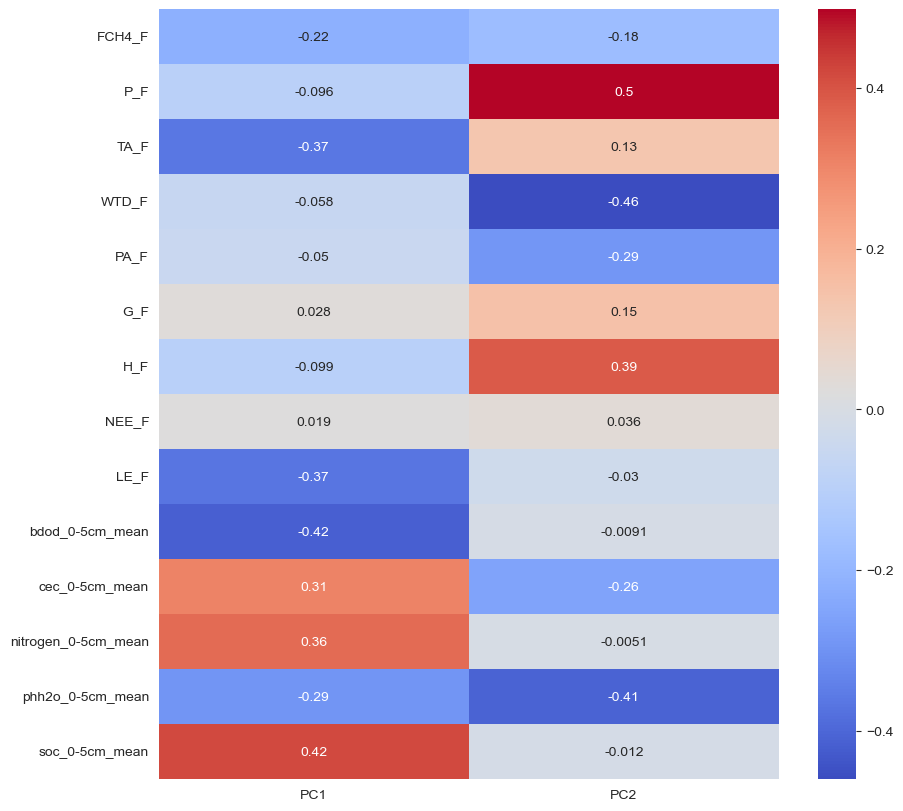

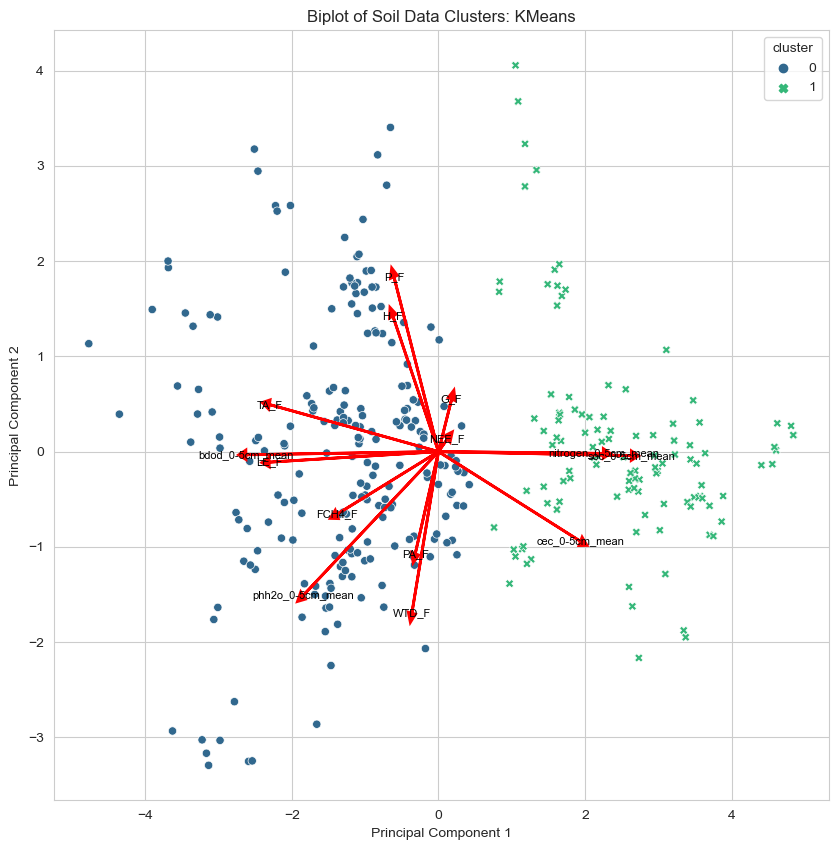

Running Hierarchical Clustering...
Explained variance for each principal component: [31.34725984 10.75427045] %


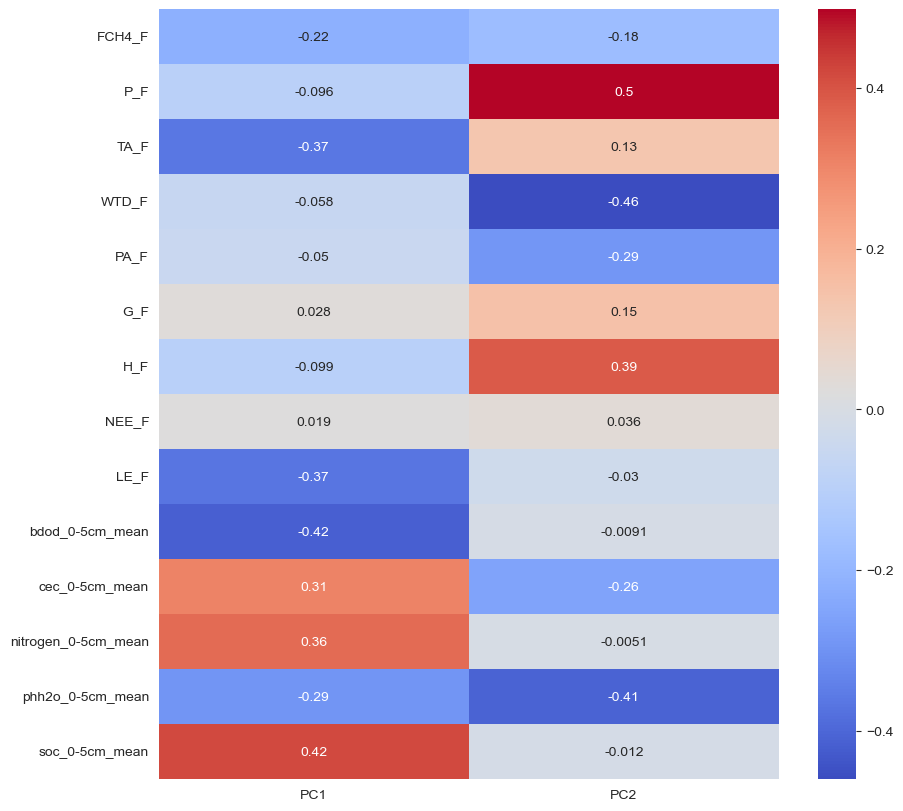

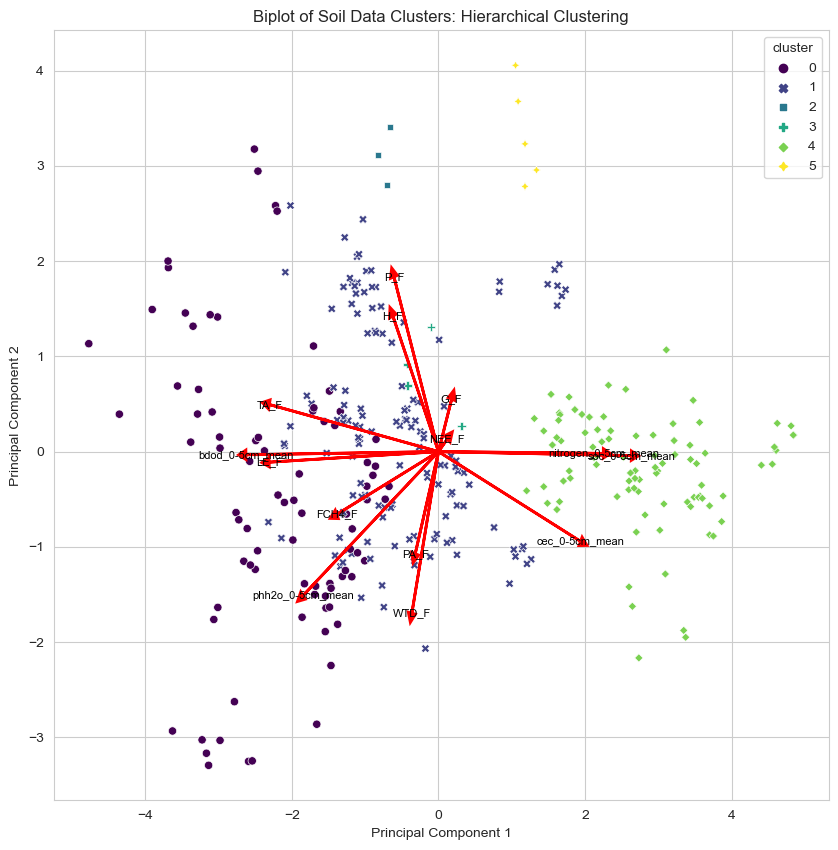

Running DBSCAN...
Explained variance for each principal component: [31.34725984 10.75427045] %


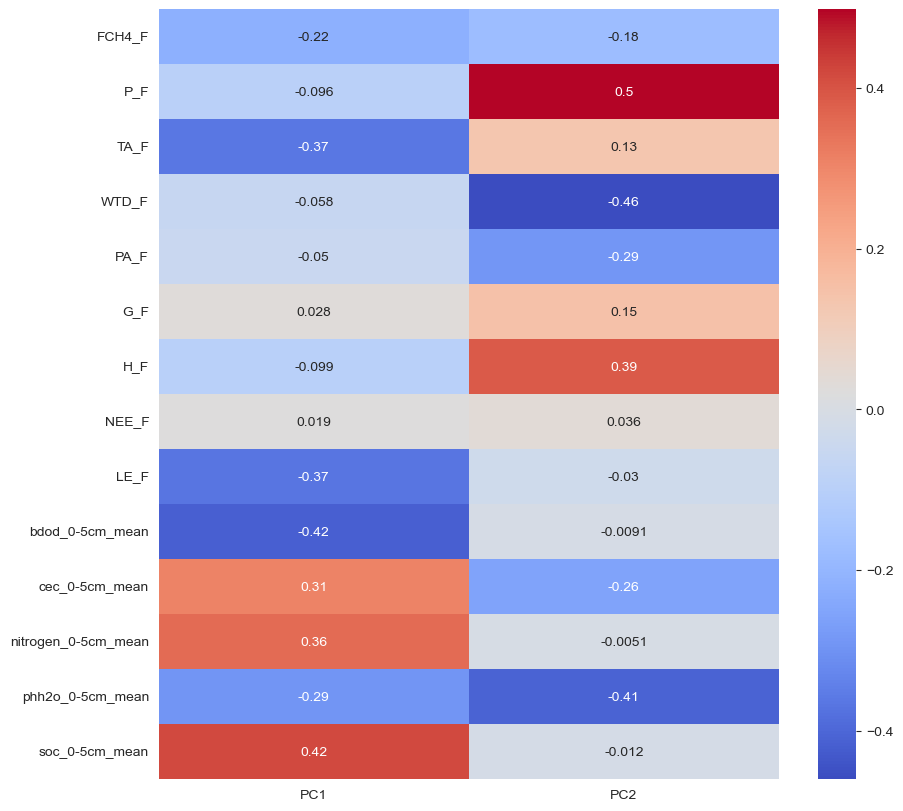

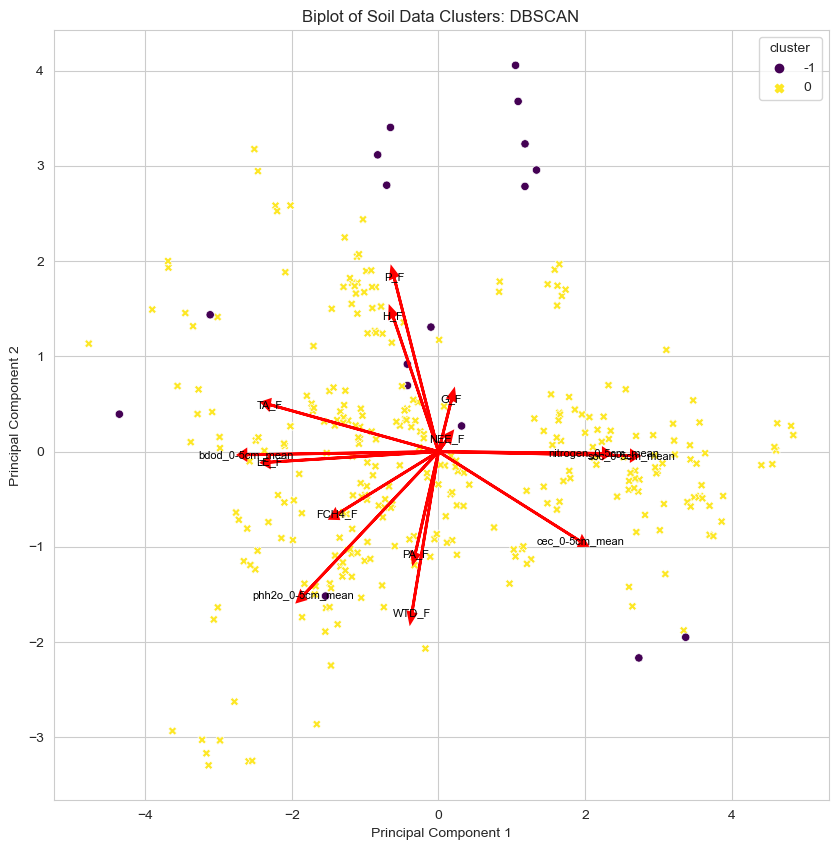

Running Gaussian Mixture Models...
Explained variance for each principal component: [31.34725984 10.75427045] %


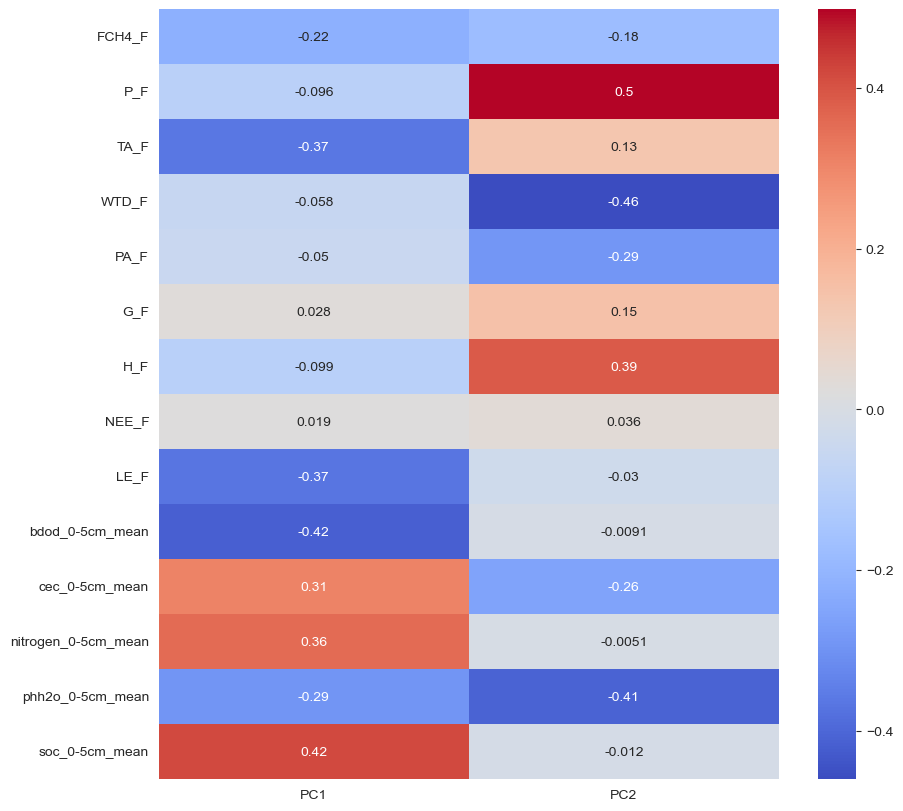

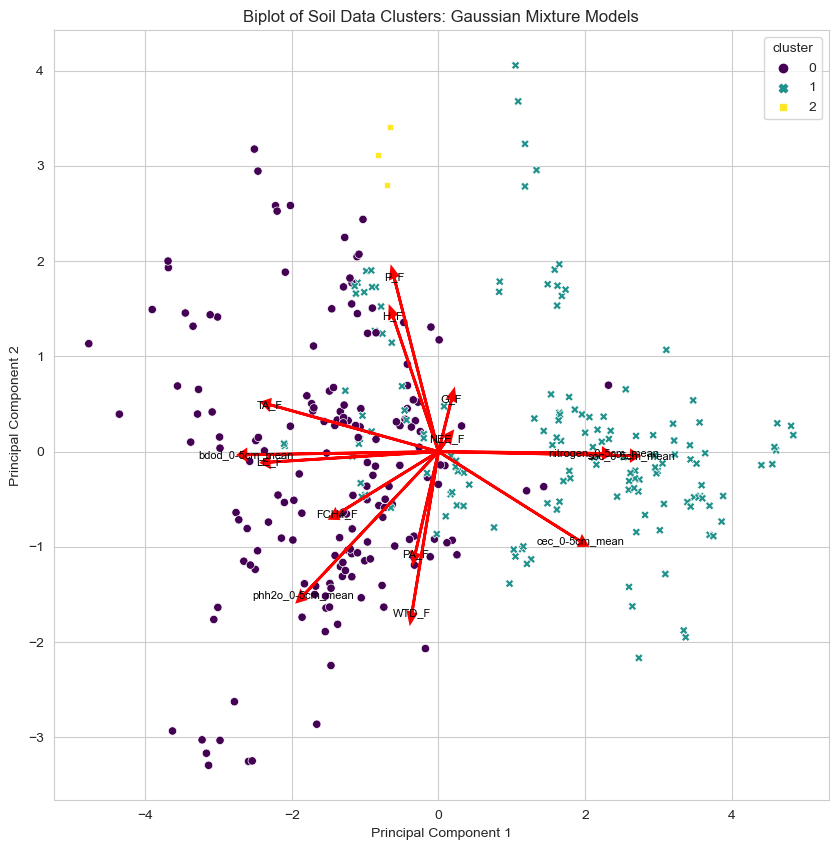

In [30]:
# Load and preprocess the data
df_grouped, num_cols = load_and_preprocess('merged_data.csv')
df_grouped_scaled = standardize_data(df_grouped, num_cols)

# List of algorithms to try
algorithms = [
    {'name': 'KMeans', 'algorithm': KMeans, 'args': {'n_clusters': 2}},
    {'name': 'Hierarchical Clustering', 'algorithm': AgglomerativeClustering, 'args': {'n_clusters': 6}},
    {'name': 'DBSCAN', 'algorithm': DBSCAN, 'args': {'eps': 4, 'min_samples': 20}},
    {'name': 'Gaussian Mixture Models', 'algorithm': GaussianMixture, 'args': {'n_components': 3}},
]

# Try each algorithm
for alg in algorithms:
    print(f"Running {alg['name']}...")
    clusters = perform_clustering(df_grouped_scaled[num_cols], alg['algorithm'], **alg['args'])
    pca, principalDf, loadings = perform_pca(df_grouped_scaled[num_cols], n_components=2)
    generate_biplot(df_grouped, principalDf, clusters, pca, num_cols, alg['name'])

In [29]:
# Perform K-means clustering
kmeans = KMeans(n_clusters=2)
kmeans_labels = kmeans.fit_predict(df_grouped_scaled[num_cols].values)

# Perform Gaussian Mixture Model (GMM) clustering
gmm = GaussianMixture(n_components=3, random_state=1)
gmm_labels = gmm.fit_predict(df_grouped_scaled[num_cols].values)

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=4, min_samples=20)
dbscan_labels = dbscan.fit_predict(df_grouped_scaled[num_cols].values)

# Perform Agglomerative Clustering
agglomerative = AgglomerativeClustering(n_clusters=6)
agglomerative_labels = agglomerative.fit_predict(df_grouped_scaled[num_cols].values)

# Calculate silhouette scores
kmeans_silhouette = silhouette_score(df_grouped_scaled[num_cols].values, kmeans_labels)
gmm_silhouette = silhouette_score(df_grouped_scaled[num_cols].values, gmm_labels)
dbscan_silhouette = silhouette_score(df_grouped_scaled[num_cols].values, dbscan_labels)
agglomerative_silhouette = silhouette_score(df_grouped_scaled[num_cols].values, agglomerative_labels)

print(f"K-means silhouette score: {kmeans_silhouette}")
print(f"GMM silhouette score: {gmm_silhouette}")
print(f"DBSCAN silhouette score: {dbscan_silhouette}")
print(f"Agglomerative silhouette score: {agglomerative_silhouette}")

K-means silhouette score: 0.2506223312028342
GMM silhouette score: 0.14780007943844986
DBSCAN silhouette score: 0.42698558451223306
Agglomerative silhouette score: 0.20139193081431397
